In [1]:
## This notebook describes how to use some basic functionalities of s4cmb such as
## * simulate an input sky
## * simulate an instrument 
## * simulate a scanning strategy
## * simulate TOD from the 3 previous guys
## * project back your TOD to sky maps.

In [2]:
import sys
import os

## Include your path to the package
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../s4cmb')))

## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import inject_crosstalk_inside_SQUID

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#########################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   MAP2TOD -> inject crosstalk -> TOD2MAP
#########################################################################

In [4]:
## Initialise our input maps 
## (for test purposes, we create the maps on-the-fly from a CAMB file)
## Note that HealpixFitsMap can take as input a fits file with sky maps already in.
sky_in = HealpixFitsMap('../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat', do_pol=True, 
                        fwhm_in=30., nside_in=256, map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=4, npair_per_squid=4,
                fp_size=60., fwhm=30., 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='stepped', freq_hwp=0., angle_hwp=0., verbose=False)

In [6]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 1 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nces=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', language='fortran')
scan.run()
print min(scan.az_min)
print min(scan.scan0['azimuth'])*180/np.pi * np.cos(30 * np.pi / 180) 

134.2263
114.903639694


In [7]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## We will use the difference of pairs of detectors to reconstruct 
## the polarisation (no demodulation).
## Once we will have the timestreams, we will reconstruct our maps on a 
## sky patch of width 20 deg at a resolution nside = 512.

nside_out = 256
state = np.random.RandomState(0)
new_gains = state.normal(1.5, 0.5, size=2*inst.focal_plane.npair)
# new_gains = np.ones(2*inst.focal_plane.npair) * 1.1
# new_gains[::2] = 1.0
## Loop over CESs
for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, 
                                  nside_out=nside_out, width=130.)
    tod_mod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, 
                                      nside_out=nside_out, width=130.)
    tod_mod.set_detector_gains(new_gains=new_gains)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot = OutputSkyMap(projection=tod.projection, 
                                   nside=nside_out, obspix=tod.obspix)
        sky_out_tot_mod = OutputSkyMap(projection=tod.projection, 
                                       nside=nside_out, obspix=tod.obspix)
        
    ## Scan input map to get TODs
    d = np.array([tod.map2tod(det) for det in tqdm(range(inst.focal_plane.nbolometer))])
    d_mod = np.array([tod_mod.map2tod(det) for det in tqdm(range(inst.focal_plane.nbolometer))])
    
    ## Project TOD to maps
    tod.tod2map(d, sky_out_tot)
    tod_mod.tod2map(d_mod, sky_out_tot_mod)

100%|██████████| 128/128 [00:05<00:00, 21.69it/s]


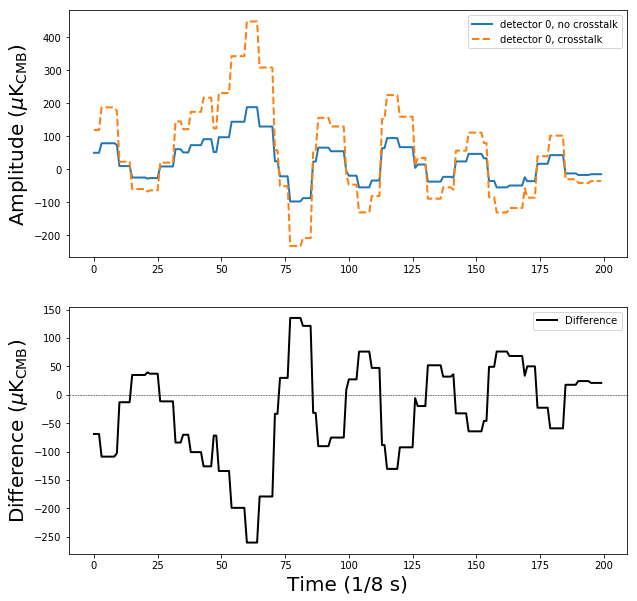

In [8]:
## Let's have a look at TODs, that is d(t) = I(t) + Q(t)cos(2*theta(t)) + U(t)sin(2*theta(t)).
## Keep in mind we set the sample rate at 8 Hz.
fig, ax = pl.subplots(2, 1, figsize=(10, 10))
ax[0].plot(d[0][0:200], label='detector 0, no crosstalk', lw=2)
ax[0].plot(d_mod[0][0:200], label='detector 0, crosstalk', ls='--', lw=2)
ax[0].legend()
ax[0].set_ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)

ax[1].plot(d[0][0:200] - d_mod[0][0:200], label='Difference', lw=2, color='black')
ax[1].axhline(0, ls='--', color='black', lw=0.5)
ax[1].set_xlabel('Time (1/8 s)', fontsize=20)
ax[1].set_ylabel('Difference ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.legend()
pl.show()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


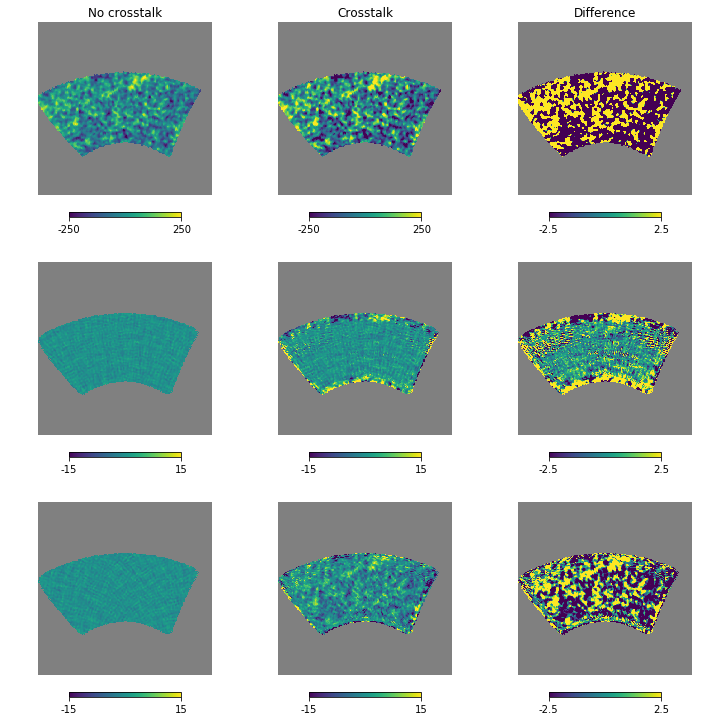

In [9]:
## Let's check the output maps
xsize = 500
reso=6.9
fig = pl.figure(figsize=(10, 10))
nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_I(), sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < 1
sky_out[mask] = np.nan
sky_out_mod[mask] = np.nan
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=331, 
            title='No crosstalk', notext=True, min=-250, max=250)
hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=reso, sub=332, 
            title='Crosstalk', notext=True, min=-250, max=250)
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=333, 
            title='Difference', notext=True, min=-2.5, max=2.5)

## Stokes Q
sky_out = partial2full(sky_out_tot.get_QU()[0], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_QU()[0], sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < np.max(nhit)/20
sky_out_mod[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=reso, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=336, 
            notext=True, title='', min=-2.5, max=2.5)

## Stokes U
sky_out = partial2full(sky_out_tot.get_QU()[1], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_QU()[1], sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < np.max(nhit)/20
sky_out_mod[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=reso, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=339, 
            notext=True, title='', min=-2.5, max=2.5)
pl.show()

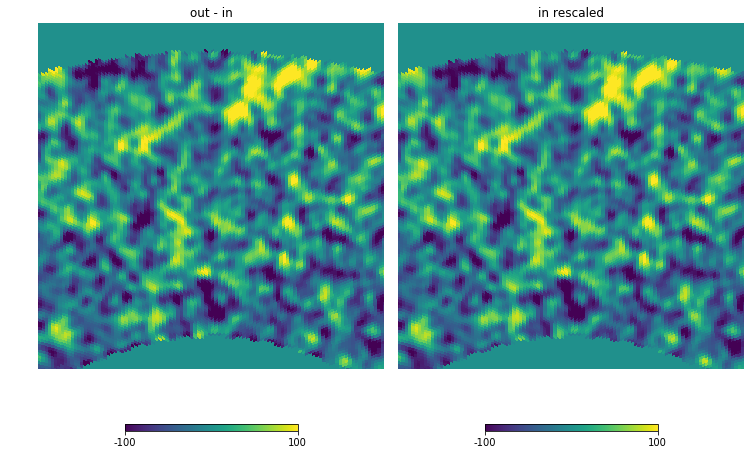

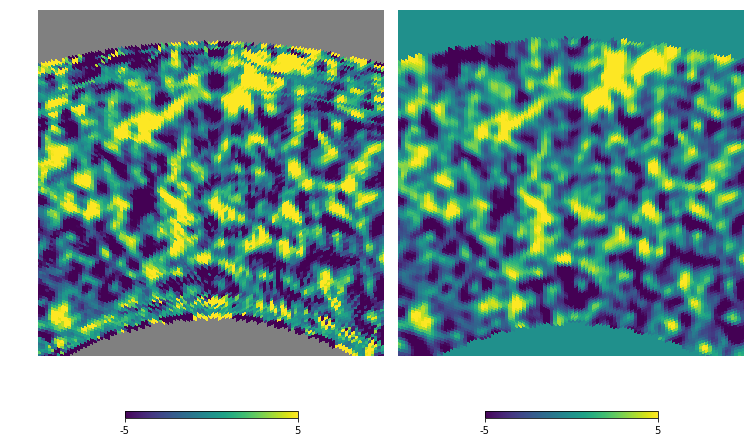

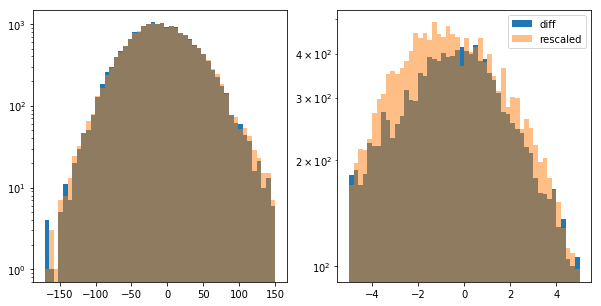

In [11]:
g_plus_eff = np.mean((new_gains[::2] + new_gains[1::2] - 2)/2)
g_minus_eff = np.mean((new_gains[::2] - new_gains[1::2])/2)

## Let's check the output maps
xsize = 1000
reso=1.7
fig = pl.figure(figsize=(10, 10))
nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

## Temperature
sky_out_I = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_I_mod = partial2full(sky_out_tot_mod.get_I(), sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < 1
sky_out[mask] = np.nan
sky_out_mod[mask] = np.nan
hp.gnomview(sky_out_I_mod - sky_out_I, rot=[0, -57.5], xsize=xsize, reso=reso, sub=121, 
            title='out - in', notext=True, min=-100, max=100)
hp.gnomview(sky_out_I * g_plus_eff, rot=[0, -57.5], xsize=xsize, reso=reso, sub=122, 
            title='in rescaled', notext=True, min=-100, max=100)
pl.show()

fig = pl.figure(figsize=(10, 10))
## Stokes U
sky_out = partial2full(sky_out_tot.get_QU()[1], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_QU()[1], sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < np.max(nhit)/20
sky_out_mod[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=121, 
            notext=True, min=-5, max=5, title='')
hp.gnomview(-sky_out_I * g_minus_eff, rot=[0, -57.5], xsize=xsize, reso=reso, sub=122, 
            notext=True, min=-5, max=5, title='')
pl.show()

fig, ax = pl.subplots(1, 2, figsize=(10, 5))
v, b, _ = ax[0].hist(sky_out_I[~mask] * g_plus_eff, bins=50)
ax[0].hist((sky_out_I_mod[~mask] - sky_out_I[~mask]), bins=b, alpha=0.5)
ax[0].set_yscale('log')

v, b, _ = ax[1].hist((sky_out_mod[~mask] - sky_out[~mask]), bins=50, alpha=1.0, range=(-5, 5), label='diff')
ax[1].hist(-sky_out_I[~mask] * g_minus_eff, bins=b, alpha=0.5, label='rescaled')
ax[1].legend()

ax[1].set_yscale('log')
pl.show()

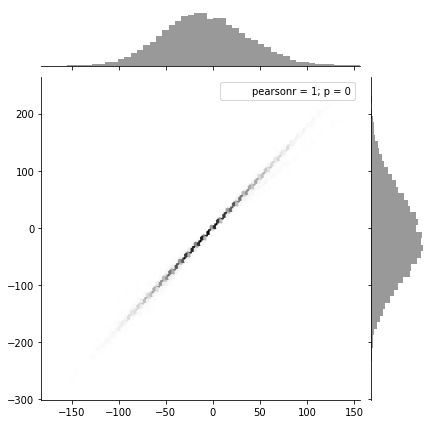

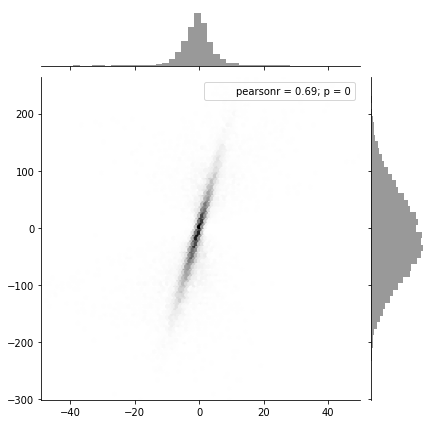

In [25]:
import seaborn as sns
sns.jointplot(sky_out_I_mod[~mask] - sky_out_I[~mask], sky_out_I[~mask], 
              kind='hex', gridsize=100, color='k')
pl.show()
mask2 = np.abs(sky_out_mod[~mask] - sky_out[~mask]) < 50
sns.jointplot((sky_out_mod[~mask] - sky_out[~mask])[mask2], sky_out_I[~mask][mask2], 
              kind='hex', gridsize=100, color='k')
pl.show()

# g = sns.jointplot(x=sky_out_I_mod[~mask] - sky_out_I[~mask], y=sky_out_I[~mask], kind="hex")
# g.plot_joint(pl.scatter, s=30, linewidth=1, marker="+")
# g.ax_joint.collections[0].set_alpha(0)
# g.set_axis_labels("$X$", "$Y$")
# pl.show()
# mask2 = np.abs(sky_out_mod[~mask] - sky_out[~mask]) < 50
# g = sns.jointplot(x=(sky_out_mod[~mask] - sky_out[~mask])[mask2], y=sky_out_I[~mask][mask2], kind="hex")
# g.plot_joint(pl.scatter, s=30, linewidth=1, marker="+")
# g.ax_joint.collections[0].set_alpha(0)
# g.set_axis_labels("$X$", "$Y$")
# pl.show()